In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torch_autoneb import suggest, config, find_minimum, neb, to_simple_graph, visualise
import torch
from torch import optim
import main
import pickle
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt
import yaml
import random
%matplotlib inline

In [3]:
# Replace this path with your own project directory
project_directory = "PATH_TO_YOUR_PROJECT"
assert os.path.isdir(project_directory), "Project directory was not found!"

In [4]:
# Set to True to load to CUDA device (False: leave in RAM)
on_device = False

# Path to config (specifiying setup and model)
config_file = os.path.join(project_directory, "config.yaml")
# config_file = "configs/cifar10-resnet20.yaml"  # if you download an MST from the Google Drive (see README.md)

model, minima_count, min_config, lex_config = main.read_config_file(config_file, on_device)
print(f"Model has {model.number_of_dimensions} dimensions.")

Files already downloaded and verified
Files already downloaded and verified
Model has 274042 dimensions.


In [5]:
model.model

DataModel(
  (model): CompareModel(
    (model): ResNet(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (non_lin1): ReLU()
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (nonlin1): ReLU()
          (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (nonlin1): ReLU()
       

In [6]:
# Load graph
graph_file = os.path.join(project_directory, "graph.p")
mst_file = os.path.join(project_directory, "mst.p")
if os.path.isfile(graph_file):
    with open(graph_file, "rb") as file:
        graph = pickle.load(file)
        simple_graph = to_simple_graph(graph, lex_config.weight_key)
elif os.path.isfile(mst_file):
    with open(mst_file, "rb") as file:
        # Avoid cluttering the namespace!
        if "graph" in locals():
            del graph
        simple_graph = pickle.load(file)
else:
    raise FileNotFoundError()

## Connectivity Graph

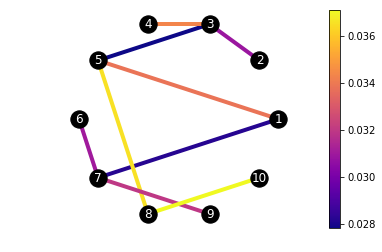

In [7]:
visualise.draw_connectivity_graph(simple_graph, lex_config.value_key, lex_config.weight_key)

## Minimum Spanning Tree

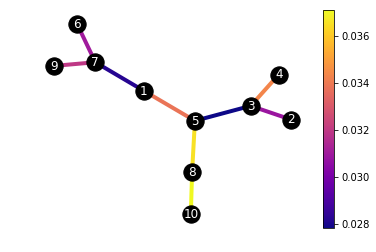

In [8]:
mst = nx.minimum_spanning_tree(simple_graph, lex_config.weight_key)
visualise.draw_connectivity_graph(mst, lex_config.value_key, lex_config.weight_key, nx.spring_layout(mst))

## Evaluation

In [9]:
node_values = torch.Tensor([mst.nodes[node][lex_config.value_key] for node in mst.nodes])
saddle_values = torch.Tensor([mst.get_edge_data(*edge)[lex_config.weight_key] for edge in mst.edges])

print("Averages over minimum spanning tree:")
print(f"Minima:  {node_values.mean().item():.4f} ± {node_values.std().item():.4f} ({lex_config.value_key})")
print(f"Saddles: {saddle_values.mean().item():.4f} ± {saddle_values.std().item():.4f} ({lex_config.weight_key})")

Averages over minimum spanning tree:
Minima:  0.0162 ± 0.0009 (train_loss)
Saddles: 0.0324 ± 0.0033 (saddle_train_loss)


## Loss along MST paths

(-0.05, 1.05)

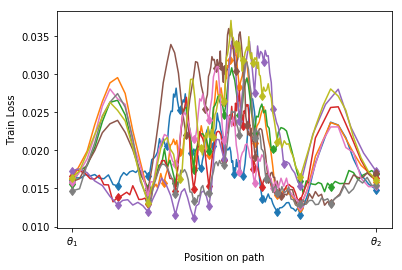

In [10]:
for edge in mst.edges:
    data = mst.get_edge_data(*edge)[lex_config.weight_key.replace("saddle", "dense")]
    lengths = mst.get_edge_data(*edge)["target_distances"]
    visualise.plot_dense(data, lengths, True)
plt.ylabel(lex_config.weight_key.replace("saddle_", "").replace("_", " ").title())
plt.xticks([0, 1], ["$\\theta_1$", "$\\theta_2$"])
plt.xlim(-0.05, 1.05)